In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import mlflow
from mlflow.models.signature import infer_signature
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# %% [markdown]
"""
## 1. Configuration MLflow
"""
# %%
# Configuration similaire au Zoomcamp
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("projet MLOps")

2025/07/16 17:53:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/16 17:53:27 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/mnt/c/Users/HP/Documents/Mlops-project/Experiment/mlruns/1', creation_time=1752684815331, experiment_id='1', last_update_time=1752684815331, lifecycle_stage='active', name='projet MLOps', tags={}>

In [3]:
"""
## 2. Chargement et préparation des données
"""
# %%
def load_data():
    """Charge et prépare les données comme dans le Zoomcamp"""
    # Chargement des données
    
    X = pd.read_csv('processed_data/X_prepared.csv')
    y = pd.read_csv('processed_data/y_prepared.csv').squeeze()
    
    # Split des données (80/20)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42,stratify=y
    )
    
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = load_data()

In [4]:
"""
## 3. Fonctions d'évaluation
"""
# %%
def eval_metrics(y_true, y_pred, y_proba):
    """Calcule les métriques comme dans le notebook de référence"""
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba[:, 1])
    }

def log_confusion_matrix(y_true, y_pred):
    """Log la matrice de confusion dans MLflow"""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")


2025/07/16 17:58:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Métriques baseline: {'accuracy': 0.7611343867522373, 'f1': 0.6331828623752992, 'roc_auc': 0.830726752910744}


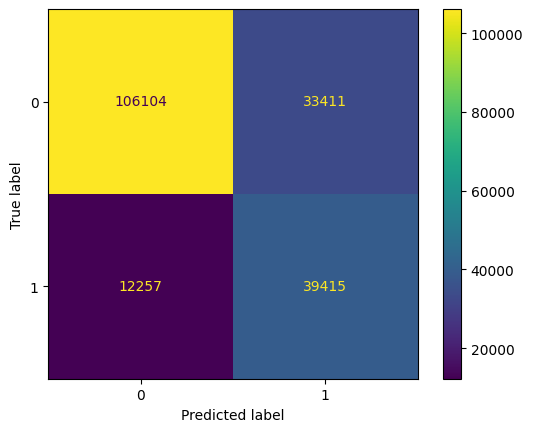

In [5]:
"""
## 4. Entraînement de base
"""
# %%
def train_baseline():
    """Entraîne un modèle baseline comme démo"""
    with mlflow.start_run(run_name="baseline"):
        # Paramètres initiaux
        params = {
            "n_estimators": 100,
            "max_depth": 10,
            "random_state": 42,
            "class_weight": "balanced"
        }
        
        # Entraînement
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        
        # Évaluation
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)
        metrics = eval_metrics(y_val, y_pred, y_proba)
        
        # Log dans MLflow 
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        
        # Signature du modèle
        signature = infer_signature(X_val, y_pred)
        mlflow.sklearn.log_model(
            model,
            "model",
            signature=signature,
            input_example=X_val.iloc[:5]
        )
        
        # Matrice de confusion
        log_confusion_matrix(y_val, y_pred)
        
        return metrics

baseline_metrics = train_baseline()
print("Métriques baseline:", baseline_metrics)

In [ ]:
"""
## 5. Optimisation avec Optuna (maximisation accuracy)
"""
# %%
def objective(trial):
    """Fonction objective pour Optuna focalisée sur l'accuracy"""
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
        "random_state": 42
    }
    
    # Entraînement
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    
    # Évaluation
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    return accuracy

def optimize():
    """Optimisation avec suivi MLflow comme dans le Zoomcamp"""
    with mlflow.start_run(run_name="optimization"):
        mlflow.set_tag("developer", "YOUSSOUF KAMAGATE")
        study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=42)
        )
        study.optimize(objective, n_trials=30)
        
        # Meilleurs paramètres
        best_params = study.best_params
        best_params["random_state"] = 42  # Forcer la reproductibilité
        
        # Entraînement final avec les meilleurs paramètres
        best_model = RandomForestClassifier(**best_params)
        best_model.fit(X_train, y_train)
        
        # Évaluation
        y_pred = best_model.predict(X_val)
        y_proba = best_model.predict_proba(X_val)
        metrics = eval_metrics(y_val, y_pred, y_proba)
        
        # Log dans MLflow
        mlflow.log_params(best_params)
        mlflow.log_metrics(metrics)
        
        # Signature du modèle
        signature = infer_signature(X_val, y_pred)
        mlflow.sklearn.log_model(
            best_model,
            "optimized_model",
            signature=signature,
            input_example=X_val.iloc[:5]
        )
        
        # Visualisations Optuna
        fig1 = plot_optimization_history(study)
        fig2 = plot_param_importances(study)
        
        fig1.write_image("optimization_history.png")
        fig2.write_image("param_importances.png")
        
        mlflow.log_artifact("optimization_history.png")
        mlflow.log_artifact("param_importances.png")
        
        return best_model, metrics

best_model, optimized_metrics = optimize()
print("Métriques optimisées:", optimized_metrics)


In [ ]:


"""
## 6. Comparaison des résultats
"""
# %%
def compare_results(baseline, optimized):
    """Compare les résultats comme dans le notebook exemple"""
    comparison = pd.DataFrame({
        "Baseline": baseline,
        "Optimized": optimized
    }).T
    
    display(comparison.style.highlight_max(axis=0))
    
    # Affichage de l'amélioration
    improvement = (optimized["accuracy"] - baseline["accuracy"]) / baseline["accuracy"]
    print(f"\nAmélioration de l'accuracy: {improvement:.2%}")

compare_results(baseline_metrics, optimized_metrics)

In [ ]:



"""
## 7. Test du modèle enregistré (comme dans le Zoomcamp)
"""
# %%
def test_model():
    """Teste le modèle chargé depuis MLflow"""
    # Charger le dernier modèle optimisé
    runs = mlflow.search_runs(order_by=["metrics.accuracy DESC"])
    best_run_id = runs.iloc[0].run_id
    
    model_uri = f"runs:/{best_run_id}/optimized_model"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    
    # Test de prédiction
    sample = X_val.iloc[:1]
    prediction = loaded_model.predict(sample)
    proba = loaded_model.predict_proba(sample)
    
    print(f"Sample: {sample.values}")
    print(f"Prediction: {prediction[0]}")
    print(f"Probabilités: {proba[0]}")

test_model()